In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

# tf
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import initializers

# datetime for manipulating date and time
import datetime

# scipy
import scipy.stats as stats
from scipy.optimize import curve_fit

random.seed(2)

## Data Preprocessing

In [101]:
# Load data
df_realtor_zip_monthly_historical = pd.read_csv("../Data/realtor_zip_monthly_historical.csv")
df_realtor_zip_monthly_current = pd.read_csv("../Data/realtor_zip_monthly_current.csv")
df_realtor_zip_monthly_hotness = pd.read_csv("../Data/realtor_zip_monthly_hotness.csv")
df_realtor_zip_monthly_historical.head()
df_realtor_zip_monthly_hotness.head()

/var/folders/jr/dnsfm9kj2575clb1_33r_09w0000gn/T/ipykernel_48987/34937813.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_realtor_zip_monthly_historical = pd.read_csv("../Data/realtor_zip_monthly_historical.csv")
/var/folders/jr/dnsfm9kj2575clb1_33r_09w0000gn/T/ipykernel_48987/34937813.py:3: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_realtor_zip_monthly_current = pd.read_csv("../Data/realtor_zip_monthly_current.csv")


,month_date_yyyymm,postal_code,zip_name,hh_rank,hotness_rank,hotness_rank_mm,hotness_rank_yy,hotness_score,supply_score,demand_score,...,median_dom_yy_day,median_dom_vs_us,page_view_count_per_property_mm,page_view_count_per_property_yy,page_view_count_per_property_vs_us,median_listing_price,median_listing_price_mm,median_listing_price_yy,median_listing_price_vs_us,quality_flag
0,202405,55912,"austin, mn",3719.0,631,-510.0,-1457.0,90.329377,84.726522,95.932233,...,-16.75,-21.25,0.062960,0.187032,2.880194,196443.5,-0.010187,-0.017291,0.443990,0
1,202404,53818,"platteville, wi",8055.0,4006,NaN,-2695.0,58.864353,30.932853,86.795854,...,-28.00,7.50,0.020629,0.197293,1.871109,350000.0,-0.071612,0.121975,0.814048,0
2,202210,45750,"marietta, oh",4246.0,5445,1068.0,588.0,52.255390,19.353234,85.157546,...,15.00,17.00,-0.082904,-0.187064,1.690776,224900.0,0.060849,0.218970,0.529176,0
3,202110,36502,"atmore, al",7214.0,8720,832.0,-1292.0,29.421105,32.991562,25.850649,...,-11.50,7.00,-0.064857,0.348910,0.691182,170000.0,-0.152965,0.069182,0.453333,0
4,202110,36426,"brewton, al",7363.0,10344,9.0,-1233.0,12.480719,4.790854,20.170583,...,-23.00,41.00,0.053638,0.417541,0.619536,218900.0,0.291445,0.326667,0.583733,0


In [92]:
# Change data types of columns to correct types
for col in ['month_date_yyyymm','zip_name']:
    df_realtor_zip_monthly_historical[col] = df_realtor_zip_monthly_historical[col].astype(str)
    
for col in ['month_date_yyyymm','zip_name']:
    df_realtor_zip_monthly_hotness[col] = df_realtor_zip_monthly_hotness[col].astype(str)
    
for col in ['postal_code', 'hotness_rank']:
    df_realtor_zip_monthly_hotness[col] = df_realtor_zip_monthly_hotness[col].astype('float64')

# Replace blanks and NaNs with NaN
df_realtor_zip_monthly_historical = df_realtor_zip_monthly_historical.replace(r'^\s*$', np.nan, regex=True)
df_realtor_zip_monthly_hotness = df_realtor_zip_monthly_hotness.replace(r'^\s*$', np.nan, regex=True)

# drop 'quality_flag = 1:  year-over-year figures may be impacted' value in zipcode
value_to_drop = 'quality_flag = 1:  year-over-year figures may be impacted'
df_realtor_zip_monthly_historical = df_realtor_zip_monthly_historical[df_realtor_zip_monthly_historical['month_date_yyyymm'] != value_to_drop]



In [93]:
# parse month_date_yyyymm
df_realtor_zip_monthly_historical['year'] = df_realtor_zip_monthly_historical['month_date_yyyymm'].str[:4]
df_realtor_zip_monthly_historical['month'] = df_realtor_zip_monthly_historical['month_date_yyyymm'].str[-2:]
df_realtor_zip_monthly_historical['date'] = pd.to_datetime(df_realtor_zip_monthly_historical['month_date_yyyymm'], format='%Y%m')
np.shape(df_realtor_zip_monthly_historical)

(2853386, 43)

In [142]:
#count and drop null or nan of important metrics
new_df = df_realtor_zip_monthly_historical.dropna(subset=['zip_name', 'median_listing_price', 'active_listing_count', 'median_days_on_market',
                                                'new_listing_count', 'price_increased_count', 'price_reduced_count', 'median_listing_price_per_square_foot',
                                                'median_square_feet', 'average_listing_price', 'total_listing_count', 'pending_listing_count',
                                                'pending_ratio'])
print('shape of historical data:',np.shape(new_df))
print(new_df.isnull().sum())

hotness_df = df_realtor_zip_monthly_hotness.dropna(subset=['hh_rank', 'median_days_on_market'])
print('shape of hotness data:',np.shape(hotness_df))
print(hotness_df.isnull().sum())

#basic stats
new_df.describe()
hotness_df.describe()

shape of historical data: (2184793, 40)
month_date_yyyymm                                0
postal_code                                      0
zip_name                                         0
median_listing_price                             0
median_listing_price_mm                     246440
median_listing_price_yy                     274942
active_listing_count                             0
active_listing_count_mm                     252003
active_listing_count_yy                     284356
median_days_on_market                            0
median_days_on_market_mm                    248427
median_days_on_market_yy                    278750
new_listing_count                                0
new_listing_count_mm                        779349
new_listing_count_yy                        785008
price_increased_count                            0
price_increased_count_mm                   1917141
price_increased_count_yy                   1894652
price_reduced_count                       

,postal_code,hh_rank,hotness_rank,hotness_rank_mm,hotness_rank_yy,hotness_score,supply_score,demand_score,median_days_on_market,median_days_on_market_mm,...,median_dom_yy_day,median_dom_vs_us,page_view_count_per_property_mm,page_view_count_per_property_yy,page_view_count_per_property_vs_us,median_listing_price,median_listing_price_mm,median_listing_price_yy,median_listing_price_vs_us,quality_flag
count,1.053460e+06,1.053460e+06,1.053460e+06,998284.000000,799038.000000,1.053460e+06,1.053460e+06,1.053460e+06,1.053460e+06,1.053456e+06,...,1.053361e+06,1.053460e+06,1.037452e+06,871087.000000,1.053460e+06,1.053460e+06,1.053457e+06,1.053368e+06,1.053460e+06,1.053460e+06
mean,4.937901e+04,7.365972e+03,6.432152e+03,27.790758,-247.676311,4.995489e+01,4.981690e+01,5.009287e+01,6.105668e+01,5.218772e-02,...,-1.747978e+00,4.881148e+00,2.126134e-02,0.149470,1.072487e+00,4.258857e+05,1.192777e-02,1.002266e-01,1.207774e+00,2.236516e-01
std,2.893931e+04,5.267834e+03,3.950141e+03,1557.544733,2656.997398,2.423052e+01,2.877593e+01,2.883399e+01,3.205766e+01,2.942545e-01,...,2.748182e+01,2.891243e+01,2.132901e-01,0.538578,6.068006e-01,4.576907e+05,4.063245e+00,8.328685e+00,1.255573e+00,4.166914e-01
min,1.001000e+03,1.000000e+00,1.000000e+00,-12124.000000,-14453.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-9.810659e-01,...,-3.382500e+02,-8.075000e+01,-9.783163e-01,-0.985000,1.432399e-02,5.000000e+01,-9.971842e-01,-9.995833e-01,1.113586e-04,0.000000e+00
25%,2.735800e+04,3.186000e+03,3.099000e+03,-729.000000,-1794.000000,3.108666e+01,2.495356e+01,2.514108e+01,3.850000e+01,-1.176471e-01,...,-1.450000e+01,-1.375000e+01,-1.081927e-01,-0.205271,6.439894e-01,2.099000e+05,-2.901099e-02,-2.974480e-02,6.182522e-01,0.000000e+00
50%,4.673700e+04,6.552000e+03,6.202000e+03,72.000000,-164.000000,5.026127e+01,4.973435e+01,5.011236e+01,5.450000e+01,4.918033e-02,...,-1.250000e+00,-7.500000e-01,-1.217356e-02,0.038897,9.567399e-01,3.229000e+05,0.000000e+00,5.870135e-02,9.193730e-01,0.000000e+00
75%,7.610700e+04,1.047500e+04,9.411000e+03,877.000000,1322.000000,6.877331e+01,7.466655e+01,7.506078e+01,7.625000e+01,2.050562e-01,...,1.150000e+01,1.725000e+01,1.073864e-01,0.364571,1.368190e+00,4.899500e+05,3.575008e-02,1.687380e-01,1.372472e+00,0.000000e+00
max,9.992900e+04,3.210400e+04,1.615800e+04,10062.000000,13893.000000,9.999501e+01,1.000000e+02,1.000000e+02,3.565000e+02,9.222222e+00,...,3.355000e+02,3.130000e+02,2.573041e+01,47.248333,5.248938e+01,1.824200e+07,4.169000e+03,7.448000e+03,4.771080e+01,1.000000e+00


In [96]:
#count and drop null or nan of all metrics
df_cleaned = df_realtor_zip_monthly_historical.dropna()
print('shape of new historical data:',np.shape(df_cleaned))
df_cleaned.isnull().sum()

shape of new historical data: (153618, 43)


month_date_yyyymm                          0
postal_code                                0
zip_name                                   0
median_listing_price                       0
median_listing_price_mm                    0
median_listing_price_yy                    0
active_listing_count                       0
active_listing_count_mm                    0
active_listing_count_yy                    0
median_days_on_market                      0
median_days_on_market_mm                   0
median_days_on_market_yy                   0
new_listing_count                          0
new_listing_count_mm                       0
new_listing_count_yy                       0
price_increased_count                      0
price_increased_count_mm                   0
price_increased_count_yy                   0
price_reduced_count                        0
price_reduced_count_mm                     0
price_reduced_count_yy                     0
pending_listing_count                      0
pending_li

In [135]:
new_df.head()

,month_date_yyyymm,postal_code,zip_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag,year,month,date,percentile_label,color_label
0,202205,13325.0,"constableville, ny",399000.0,-0.2570,2.3278,3.0,0.5000,-0.4000,121.0,...,0.0000,0.6667,-1.3333,NaN,1.0,2022,05,2022-05-01,6,Yellow
1,202402,60119.0,"elburn, il",463650.0,-0.0132,0.0727,31.0,-0.0606,0.2400,68.0,...,0.4574,1.1613,0.5552,0.2013,1.0,2024,02,2024-02-01,8,Red
2,201706,55614.0,"silver bay, mn",147450.0,NaN,NaN,32.0,NaN,NaN,61.0,...,NaN,0.1563,NaN,NaN,NaN,2017,06,2017-06-01,4,Yellow
3,202306,40077.0,"westport, ky",672500.0,0.1520,0.5824,2.0,0.3333,1.0000,37.0,...,1.5000,0.5000,-0.1667,0.0000,1.0,2023,06,2023-06-01,4,Yellow
4,202006,83402.0,"idaho falls, id",277450.0,0.2470,0.1936,33.0,-0.1447,-0.1447,14.0,...,-0.0658,0.1077,0.0024,0.0814,0.0,2020,06,2020-06-01,2,Green


In [136]:
hotness_df.head()

,month_date_yyyymm,postal_code,zip_name,hh_rank,hotness_rank,hotness_rank_mm,hotness_rank_yy,hotness_score,supply_score,demand_score,...,median_dom_yy_day,median_dom_vs_us,page_view_count_per_property_mm,page_view_count_per_property_yy,page_view_count_per_property_vs_us,median_listing_price,median_listing_price_mm,median_listing_price_yy,median_listing_price_vs_us,quality_flag
0,202405,55912.0,"austin, mn",3719.0,631.0,-510.0,-1457.0,90.329377,84.726522,95.932233,...,-16.75,-21.25,0.062960,0.187032,2.880194,196443.5,-0.010187,-0.017291,0.443990,0
1,202404,53818.0,"platteville, wi",8055.0,4006.0,NaN,-2695.0,58.864353,30.932853,86.795854,...,-28.00,7.50,0.020629,0.197293,1.871109,350000.0,-0.071612,0.121975,0.814048,0
2,202210,45750.0,"marietta, oh",4246.0,5445.0,1068.0,588.0,52.255390,19.353234,85.157546,...,15.00,17.00,-0.082904,-0.187064,1.690776,224900.0,0.060849,0.218970,0.529176,0
3,202110,36502.0,"atmore, al",7214.0,8720.0,832.0,-1292.0,29.421105,32.991562,25.850649,...,-11.50,7.00,-0.064857,0.348910,0.691182,170000.0,-0.152965,0.069182,0.453333,0
4,202110,36426.0,"brewton, al",7363.0,10344.0,9.0,-1233.0,12.480719,4.790854,20.170583,...,-23.00,41.00,0.053638,0.417541,0.619536,218900.0,0.291445,0.326667,0.583733,0


In [156]:
#merge two dataset
merged_df = pd.merge(new_df, hotness_df, on=['month_date_yyyymm', 'postal_code'], how = 'outer')

#create a new coalesced column for zip nme, median days on mrket
merged_df['zip_name'] = merged_df['zip_name_x'].combine_first(merged_df['zip_name_y'])
merged_df['median_days_on_market'] = merged_df['median_days_on_market_x'].combine_first(merged_df['median_days_on_market_y'])
merged_df['median_listing_price_mm'] = merged_df['median_listing_price_mm_x'].combine_first(merged_df['median_listing_price_mm_y'])
merged_df['median_listing_price_yy'] = merged_df['median_listing_price_yy_x'].combine_first(merged_df['median_listing_price_yy_y'])
merged_df['median_days_on_market_mm'] = merged_df['median_days_on_market_mm_x'].combine_first(merged_df['median_days_on_market_mm_y'])
merged_df['median_days_on_market_yy'] = merged_df['median_days_on_market_yy_x'].combine_first(merged_df['median_days_on_market_yy_y'])
merged_df['quality_flag'] = merged_df['quality_flag_x'].combine_first(merged_df['quality_flag_y'])


merged_df.columns

Index(['month_date_yyyymm', 'postal_code', 'zip_name_x',
       'median_listing_price_x', 'median_listing_price_mm_x',
       'median_listing_price_yy_x', 'active_listing_count',
       'active_listing_count_mm', 'active_listing_count_yy',
       'median_days_on_market_x', 'median_days_on_market_mm_x',
       'median_days_on_market_yy_x', 'new_listing_count',
       'new_listing_count_mm', 'new_listing_count_yy', 'price_increased_count',
       'price_increased_count_mm', 'price_increased_count_yy',
       'price_reduced_count', 'price_reduced_count_mm',
       'price_reduced_count_yy', 'pending_listing_count',
       'pending_listing_count_mm', 'pending_listing_count_yy',
       'median_listing_price_per_square_foot',
       'median_listing_price_per_square_foot_mm',
       'median_listing_price_per_square_foot_yy', 'median_square_feet',
       'median_square_feet_mm', 'median_square_feet_yy',
       'average_listing_price', 'average_listing_price_mm',
       'average_listing_price_yy

In [160]:
print(np.shape(merged_df))
print(merged_df.isnull().sum())

merged_df['price_reduced_count'].isnull().sum()

(3238253, 69)
month_date_yyyymm                  0
postal_code                        0
zip_name_x                   1053460
median_listing_price_x       1053460
median_listing_price_mm_x    1299900
                              ...   
median_listing_price_mm       246443
median_listing_price_yy       275034
median_days_on_market_mm      248431
median_days_on_market_yy      278849
quality_flag                  229548
Length: 69, dtype: int64


1053460

In [161]:
merged_df[['month_date_yyyymm', 'postal_code', 'zip_name', 'price_reduced_count', 'hotness_score']]

,month_date_yyyymm,postal_code,zip_name,price_reduced_count,hotness_score
0,202408,32343.0,"midway, fl",4.0,NaN
1,202408,62896.0,"west frankfort, il",4.0,NaN
2,202408,56477.0,"sebeka, mn",0.0,NaN
3,202408,25315.0,"charleston, wv",0.0,NaN
4,202408,76454.0,"gorman, tx",0.0,NaN
...,...,...,...,...,...
3238248,201807,96732.0,"kahului, hi",NaN,67.153215
3238249,201711,95370.0,"sonora, ca",NaN,72.097354
3238250,201804,92227.0,"brawley, ca",NaN,36.124890
3238251,201709,78962.0,"weimar, tx",NaN,44.860131


In [148]:
new_df[new_df['postal_code'] == 83811.0]
new_df[(new_df['postal_code'] == 83811.0) & (new_df['month_date_yyyymm'] == '201802')]

,month_date_yyyymm,postal_code,zip_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag


## Exploratory graphs

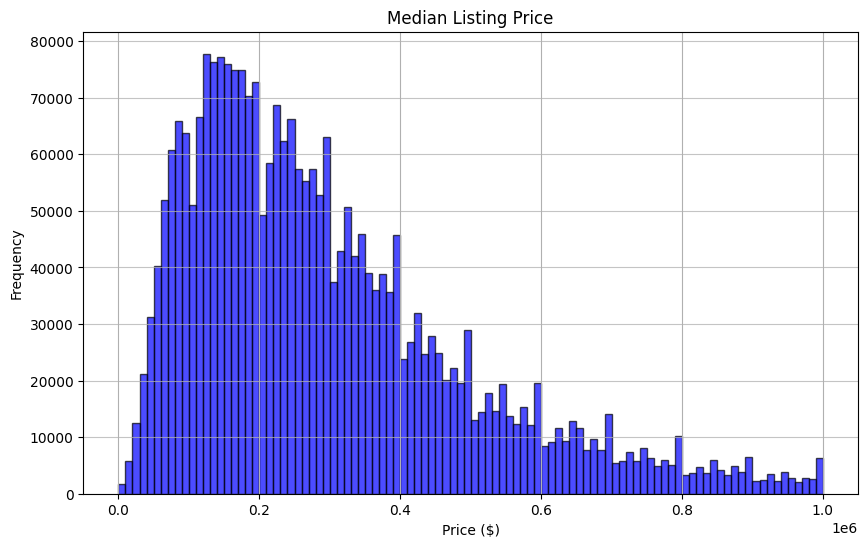

In [97]:
#median listing price
plt.figure(figsize=(10, 6))
df_realtor_zip_monthly_historical['median_listing_price'].hist(bins=100, color='blue', alpha=0.7, edgecolor='black', range=(0, 1000000))
plt.title('Median Listing Price')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

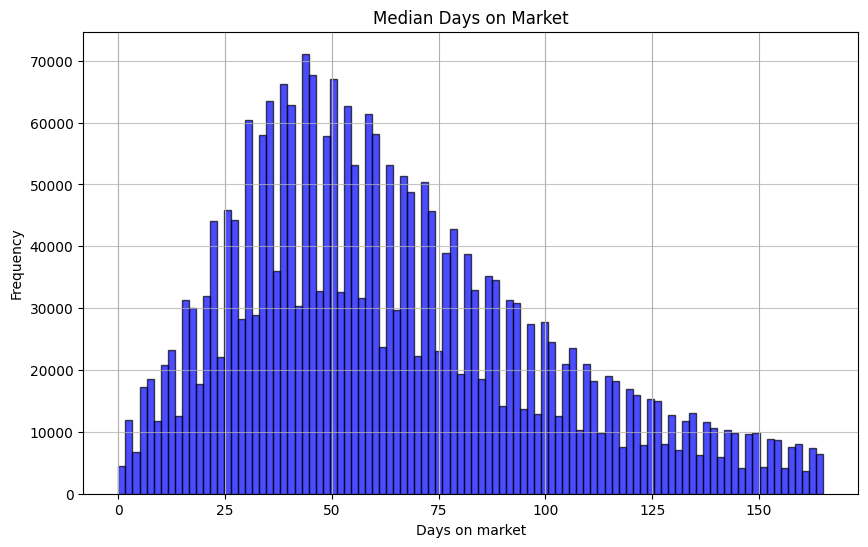

In [98]:
#median days on market
plt.figure(figsize=(10, 6))
df_realtor_zip_monthly_historical['median_days_on_market'].hist(bins=100, color='blue', alpha=0.7, edgecolor='black', range=(0, 165))
plt.title('Median Days on Market')
plt.xlabel('Days on market')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

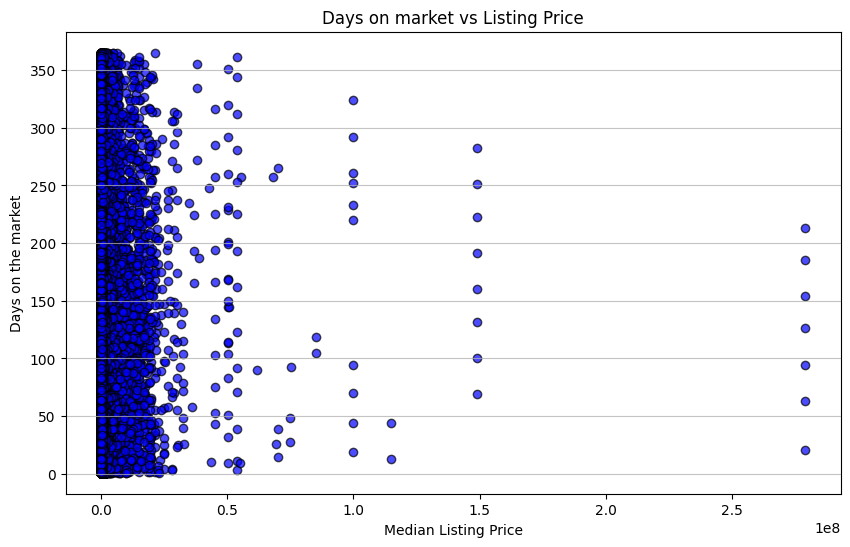

In [99]:
#days on market vs listing price
plt.figure(figsize=(10, 6))
plt.scatter(df_realtor_zip_monthly_historical['median_listing_price'], df_realtor_zip_monthly_historical['median_days_on_market'], color='blue', alpha=0.7, edgecolor='black')
plt.title('Days on market vs Listing Price')
plt.xlabel('Median Listing Price')
plt.ylabel('Days on the market')
plt.grid(axis='y', alpha=0.75)
plt.show()

## Assigning group

In [100]:
def assign_label(group):
    """
    Classify median days on market based on percentile
    """
    quantile_10 = group['median_days_on_market'].quantile(0.10)
    quantile_20 = group['median_days_on_market'].quantile(0.20)
    quantile_30 = group['median_days_on_market'].quantile(0.30)
    quantile_40 = group['median_days_on_market'].quantile(0.40)
    quantile_50 = group['median_days_on_market'].quantile(0.50)
    quantile_60 = group['median_days_on_market'].quantile(0.60)
    quantile_70 = group['median_days_on_market'].quantile(0.70)
    quantile_80 = group['median_days_on_market'].quantile(0.80)
    quantile_90 = group['median_days_on_market'].quantile(0.90)
    
    def get_label(value):
        if value <= quantile_10:
            return 1
        elif value <= quantile_20:
            return 2
        elif value <= quantile_30:
            return 3
        elif value <= quantile_40:
            return 4
        elif value <= quantile_50:
            return 5
        elif value <= quantile_60:
            return 6
        elif value <= quantile_70:
            return 7
        elif value <= quantile_80:
            return 8
        elif value <= quantile_90:
            return 9
        else:
            return 10
        
    def get_color(value):
        if value <= quantile_30:
            return 'Green'
        elif value <= quantile_60:
            return 'Yellow'
        else:
            return 'Red'
    
    group['percentile_label'] = group['median_days_on_market'].apply(get_label)
    group['color_label'] = group['median_days_on_market'].apply(get_color)
    return group

# Apply the function to each group
new_df = new_df.groupby('postal_code').apply(assign_label)

# Reset the data frame
new_df = new_df.reset_index(drop=True)

#Shuffling the data frame
new_df = new_df.sample(frac=1).reset_index(drop=True)

new_df.head()

,month_date_yyyymm,postal_code,zip_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag,year,month,date,percentile_label,color_label
0,202205,13325.0,"constableville, ny",399000.0,-0.2570,2.3278,3.0,0.5000,-0.4000,121.0,...,0.0000,0.6667,-1.3333,NaN,1.0,2022,05,2022-05-01,6,Yellow
1,202402,60119.0,"elburn, il",463650.0,-0.0132,0.0727,31.0,-0.0606,0.2400,68.0,...,0.4574,1.1613,0.5552,0.2013,1.0,2024,02,2024-02-01,8,Red
2,201706,55614.0,"silver bay, mn",147450.0,NaN,NaN,32.0,NaN,NaN,61.0,...,NaN,0.1563,NaN,NaN,NaN,2017,06,2017-06-01,4,Yellow
3,202306,40077.0,"westport, ky",672500.0,0.1520,0.5824,2.0,0.3333,1.0000,37.0,...,1.5000,0.5000,-0.1667,0.0000,1.0,2023,06,2023-06-01,4,Yellow
4,202006,83402.0,"idaho falls, id",277450.0,0.2470,0.1936,33.0,-0.1447,-0.1447,14.0,...,-0.0658,0.1077,0.0024,0.0814,0.0,2020,06,2020-06-01,2,Green


## Feature Engineering

Composite decision-tree and greedy feature selection
The following code uses two algorithms to select the most relevant features:

1. Decision tree feature selection returns importance scores of each feature in predicting depression classes
2. Greedy feature selection uses a correlation matrix, identifies features that have the highest correlation with the depression classes, and drops features that are highly correlated with the selected features. It repeats this process

A composite score for each feature is then calculated based on the outcomes of each of these algorithms.

Finally, a new dataframe it outputted that contains the top 30 features based on the composite score.

In [ ]:
def feature_selection_decision_tree(df, cols_to_drop=['number', 'madrs2_grouped', 'Normal', 'Mild', 'Moderate'], y_col='madrs2_grouped_ord'):
    """
    Uses a decision tree to calculate feature importances and returns a DataFrame with the feature names and importances.

    Params:
        df: DataFrame with features and MADRS2 Groups (Normal, Mild, Moderate)
        cols_to_drop: List of columns to drop from df
        y_col: Name of column containing MADRS2 Groups (Ordinal)
        
    Returns:
        df_importances: DataFrame with feature names and importances
    """
    # Drop 'number'
    df = df.drop(cols_to_drop, axis=1)
    
    # Set up and fit Decision Tree
    y = df[y_col]
    X = df.drop(columns=y_col)
    tree = DecisionTreeClassifier(class_weight='balanced', random_state=0)
    tree.fit(X, y)

    # Get feature importances and names
    feature_importances = tree.feature_importances_
    feature_names = X.columns

    # Combine importances and names into DataFrame and sort by importance
    df_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances,
    }).sort_values(by='importance', ascending=False)

    # Reset index of df_importances
    df_importances = df_importances.reset_index(drop=True)

    # Drop rows with importance of 0
    df_importances = df_importances[df_importances['importance'] > 0]

    return df_importances

def feature_selection_greedy(df, cols_to_drop=['number', 'madrs2_grouped', 'madrs2_grouped_ord'], corr_drop_threshold=0.8):
    """
    Uses a greedy algorithm to select features that are highly correlated with MADRS2 Group and not highly correlated with each other.

    Params:
        df: DataFrame with features and MADRS2 Groups (Normal, Mild, Moderate)
        cols_to_drop: List of columns to drop from df
        corr_drop_threshold: Threshold for dropping highly correlated features

    Returns:
        selected_features: DataFrame with feature names and MADRS2 Group correlation
    """
    # Drop columns
    df = df.drop(cols_to_drop, axis=1)

    # Initialize a list for selected features and the correlation matrix
    selected_features = {}
    corr = df.corr().abs()

    # Calculate 'MADRS2 Predictive score' by averaging the absolute values of 'Normal', 'Mild' and 'Moderate'
    corr['madrs2_predictive_score'] = (corr['Normal'].abs() + corr['Mild'].abs() + corr['Moderate'].abs())/3

    # Delete 'Normal' 'Mild' 'Moderate' columns
    corr = corr.drop(columns=['Normal', 'Mild', 'Moderate'])

    # Remove 'Normal' 'Mild' 'Moderate' and 'madrs2_predictive_score' rows
    corr = corr.drop(index=['Normal', 'Mild', 'Moderate'])

    # Greedy feature selection
    while not corr.empty:
        # Select feature with highest 'madrs2_predictive_score'
        next_feature = corr['madrs2_predictive_score'].idxmax()
        
        # Add selected feature and its 'madrs2_predictive_score' to the dataframe
        selected_features[next_feature] = corr.loc[next_feature, 'madrs2_predictive_score']

        # Remove selected feature and features highly correlated with it
        correlated_features = corr[next_feature][corr[next_feature] > corr_drop_threshold].index
        corr = corr.drop(columns=[next_feature] + list(correlated_features))
        corr = corr.drop(index=[next_feature] + list(correlated_features))

    # Convert selected_features to a DataFrame, calling the first column 'feature' and the second column 'madrs2_predictive_score'
    selected_features = pd.DataFrame(list(selected_features.items()), columns=['feature', 'madrs2_predictive_score'])
    
    return selected_features

df_greedy_feature = feature_selection_greedy(df_features, corr_drop_threshold=0.9)
df_decision_tree_feature = feature_selection_decision_tree(df_features)

In [ ]:
def merge_feature_selection(df_greedy = df_greedy_feature, df_decision_tree = df_decision_tree_feature):
    """
    Merges the greedy and decision tree feature selection results and calculates an average score for each feature.

    Params:
        df_greedy: DataFrame with features and MADRS2 Predictive Scores from greedy feature selection
        df_decision_tree: DataFrame with features and importances from decision tree feature selection
        
    Returns:
        df_feature_selection: DataFrame with features, individual and average scores
    """
    # Merge greedy and decision tree feature selection
    df_feature_selection = pd.merge(df_greedy_feature, df_decision_tree, how='outer', on='feature', suffixes=('_greedy', '_decision_tree'))
    df_feature_selection.columns = ['feature', 'madrs2_predictive_score_greedy', 'importance_decision_tree']

    # Replace nan with 0
    df_feature_selection = df_feature_selection.fillna(0)

    # Normalize the scores using sklearn's minmax scaler
    scaler = MinMaxScaler()
    df_feature_selection[['madrs2_predictive_score_greedy', 'importance_decision_tree']] = scaler.fit_transform(df_feature_selection[['madrs2_predictive_score_greedy', 'importance_decision_tree']])

    # Calculate average score as a new column
    df_feature_selection['average_score'] = (df_feature_selection['madrs2_predictive_score_greedy'] + df_feature_selection['importance_decision_tree']) / 2

    # Sort by average score
    df_feature_selection = df_feature_selection.sort_values(by='average_score', ascending=False)

    # Reindex
    df_feature_selection = df_feature_selection.reset_index(drop=True)

    # Make each column display in 2 decimal places
    df_feature_selection = df_feature_selection.round(2)

    return df_feature_selection

df_feature_scores = merge_feature_selection(df_greedy_feature, df_decision_tree_feature)

In [ ]:
# Create new DataFrame with only the top 30 selected features
def create_top_features_df(df, df_feature_scores=df_feature_scores, top_n=len(df_feature_scores)):
    """
    Creates a new DataFrame with only the top n features, number and madrs2 grouping columns

    Params:
        df: DataFrame with features, number and MADRS2 Groups (Normal, Mild, Moderate)
        df_feature_scores: DataFrame with feature names sorted by average score per feature

    Returns:
        df_top_features: DataFrame with top n features, number and MADRS2 Groups (Normal, Mild, Moderate)
    """
    # Create a list of columns to keep
    cols_to_keep = list(['number', 'madrs2_grouped', 'madrs2_grouped_ord', 'Normal', 'Mild', 'Moderate'])

    # Take top n features from df_feature_scores
    top_features = list(df_feature_scores['feature'][:top_n])

    # Sort top_features alphabetically
    top_features.sort()
    
    # Add top features to cols_to_keep
    cols_to_keep.extend(top_features)

    # Create a new DataFrame with only the top features
    df_top_features = df[cols_to_keep].copy()

    return df_top_features

df_selected_features = create_top_features_df(df_features, df_feature_scores=df_feature_scores, top_n=30)

In [ ]:
def plot_feature_correlation(data, cols_to_drop=['number', 'madrs2_grouped'], figsize=(30, 30), simple=False, row_start=4, col_end=4, fontsize=12, title='Feature Correlation'):
    """
    Plot a correlation heatmap of features
    
    Params:
        data: dataframe containing features to plot
        cols_to_drop: columns to drop from data before plotting
        figsize: size of heatmap
        simple: flag to indicate whether to plot a simple heatmap or not
        row_start: row to start plotting from
        col_end: column to end plotting at
        fontsize: size of font for annotations
    """
    data = data.drop(cols_to_drop, axis=1)   
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=fontsize)
    
    if simple:
        ax = sns.heatmap(data.corr().iloc[row_start:, :col_end],
                    annot=True,
                    cmap='coolwarm_r',
                    fmt='.2f',
                    annot_kws={"fontsize":fontsize},
                    linewidths=3)
    else:
        ax = sns.heatmap(data.corr(),
                    annot=True,
                    cmap='coolwarm_r',
                    fmt='.2f',
                    annot_kws={"fontsize":fontsize},
                    linewidths=3)
    
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

In [ ]:
# Plot correlation heatmap of all features. Note that the first four columns are labels.
plot_feature_correlation(data=df_selected_features)
plot_feature_correlation(data=df_selected_features, figsize=(20, 15), fontsize=16, simple=True)

Things to do:

- more work on the merge quesries
- figure out zip_name_x vs zip_name_y 
- Feature engineering work



Modeling questions:
- How do we handle Nan values?
- How do we want to factor zipcode?